# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [137]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow_data_validation as tfdv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import aequitas as ae
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, \
                    average_precision_score, recall_score, precision_recall_curve, \
                    precision_score, accuracy_score, f1_score, r2_score, mean_squared_error
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

## Determine Level of Dataset (Line or Encounter)

In [4]:
display(df.info())
display(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      143424 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    143424 non-null  object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                143424 non-null  object
 11  medical_specialty         143424 non-null  object
 12  primary_diagnosis_code    143424 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

None

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,1.434240e+05,1.434240e+05,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,1.674290e+08,5.493608e+07,2.027694,3.655316,5.701096,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,1.019046e+08,3.857840e+07,1.427585,5.219279,4.064532,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8.829596e+07,2.357219e+07,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,1.547637e+08,4.630783e+07,1.000000,1.000000,7.000000,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,2.320897e+08,8.823627e+07,3.000000,3.000000,7.000000,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [5]:
# check the level of the dataset
print(f'There are {len(df)} lines and \n{len(df["encounter_id"].unique())} unique encounters in the dataset.')
if len(df) == len(df['encounter_id'].unique()):
    print('It is encouter level dataset.')
elif len(df) > len(df['encounter_id'].unique()):
    print('It is a line level dataset.')   
else: print('It coluld be a longituginal dataset')

There are 143424 lines and 
101766 unique encounters in the dataset.
It is a line level dataset.


**Response Q1:** This is a **line level** dataset because of the number of records is more than the number of unique encounters. The dataset may represent of all the things that might happen in a medical visit or encounter.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

In [6]:
#a. Field(s) with high amount of missing/zero values
df_new = df.replace('?', np.nan).replace('None', np.nan)
missing_info = df_new.isnull().mean().sort_values(ascending=False)
print('The ratio of missing data for each column if there is any:\n')
print(missing_info[missing_info > 0.].to_string(header=None))
print('\n\nColumns without missing data:\n')
col_no_miss_ls = list(missing_info[missing_info == 0.].keys())
for x in col_no_miss_ls: print(x)

The ratio of missing data for each column if there is any:

weight                    0.970005
max_glu_serum             0.951089
A1Cresult                 0.820295
medical_specialty         0.484319
payer_code                0.377831
ndc_code                  0.163585
race                      0.023071
primary_diagnosis_code    0.000230


Columns without missing data:

patient_nbr
gender
age
admission_type_id
discharge_disposition_id
admission_source_id
time_in_hospital
readmitted
change
other_diagnosis_codes
number_outpatient
number_inpatient
number_emergency
num_lab_procedures
number_diagnoses
num_medications
num_procedures
encounter_id


**Response Q2a**: The columns with missing data are: weight (97%), max_glu_serum (95%), A1Cresult (82%), 
medical_specialty (48%), payer_code (38%), ndc_code (16%), race (2.3%), primary_diagnosis_code (0.02%). It is worth to remove columns with the missed values ratio more than 0.5, then we will think about what to do with the rest.

In [7]:
# remove columns with more thatn 50% missed values
df_new = df_new.drop(columns = ['weight', 'max_glu_serum', 'A1Cresult'])
display(df_new.info())
display(df_new.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      140115 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   admission_type_id         143424 non-null  int64 
 6   discharge_disposition_id  143424 non-null  int64 
 7   admission_source_id       143424 non-null  int64 
 8   time_in_hospital          143424 non-null  int64 
 9   payer_code                89234 non-null   object
 10  medical_specialty         73961 non-null   object
 11  primary_diagnosis_code    143391 non-null  object
 12  other_diagnosis_codes     143424 non-null  object
 13  number_outpatient         143424 non-null  int64 
 14  numb

None

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,1.434240e+05,1.434240e+05,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,1.674290e+08,5.493608e+07,2.027694,3.655316,5.701096,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,1.019046e+08,3.857840e+07,1.427585,5.219279,4.064532,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8.829596e+07,2.357219e+07,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,1.547637e+08,4.630783e+07,1.000000,1.000000,7.000000,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,2.320897e+08,8.823627e+07,3.000000,3.000000,7.000000,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


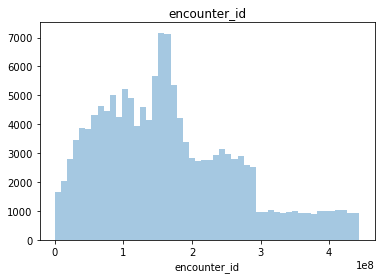

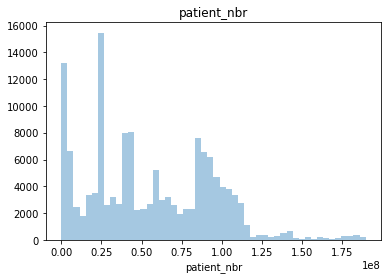

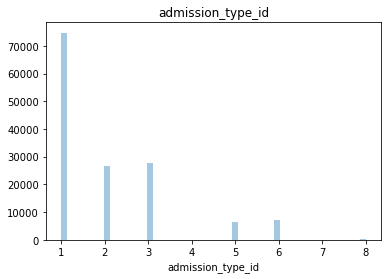

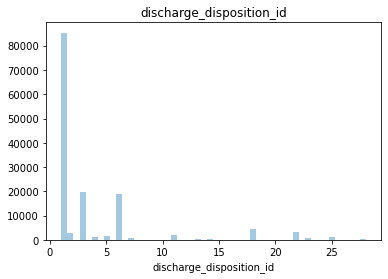

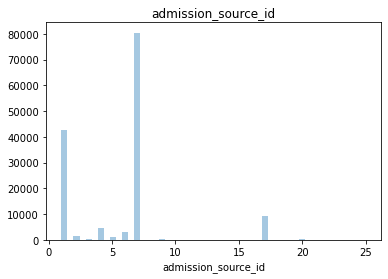

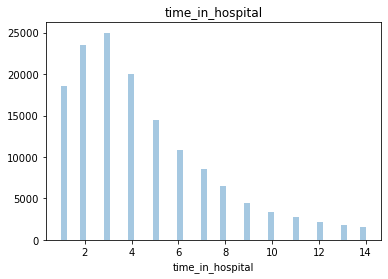

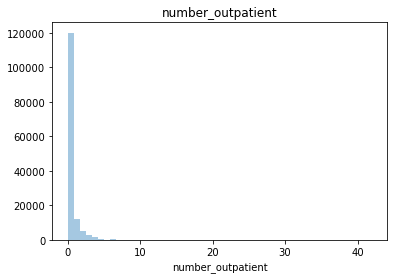

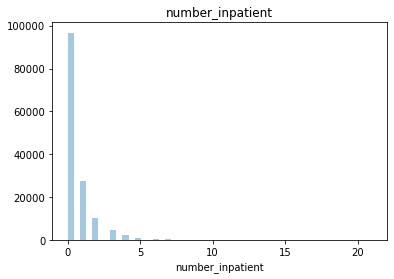

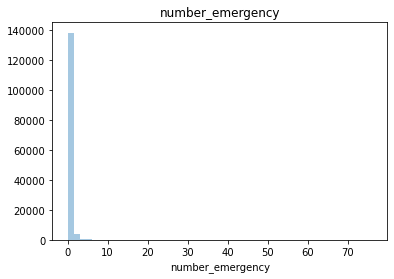

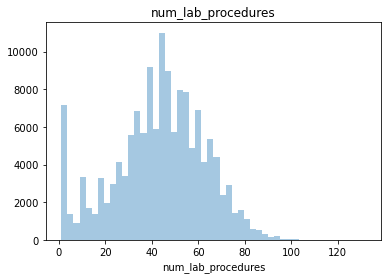

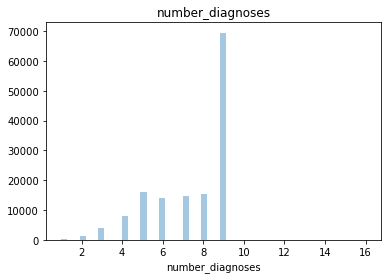

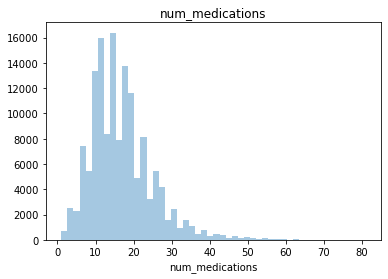

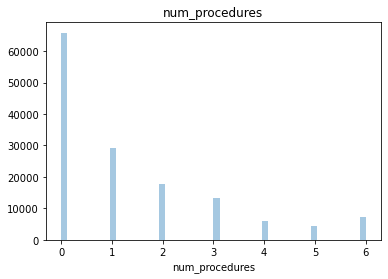

In [8]:
# b. Based off the frequency histogram for each numerical field, 
# which numerical field(s) has/have a Gaussian(normal) distribution shape?
num_col_ls = list(df_new.select_dtypes(['int64']).columns)
for col_name in num_col_ls:
    sns.distplot(df_new[col_name], kde=False)
    plt.title(col_name)
    plt.show()    

**Response Q2b**: The following numerical fields have a Gaussian distribution shapes:
- ecounter_id (skewed right)
- num_lab_procedures (slightly skewed left)
- num_medications (slightly skewed right)

In [9]:
# c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
cat_col_ls = list(df_new.select_dtypes(['object']).columns)
cat_col_ls.extend(['admission_type_id','discharge_disposition_id', 'admission_source_id'])
df_new[cat_col_ls] = df_new[cat_col_ls].astype('str')
cardinality_df = pd.DataFrame({'columns': cat_col_ls, 'cardinality': df_new[cat_col_ls].nunique() } ).sort_values('cardinality', ascending=False)
cardinality_df

,columns,cardinality
other_diagnosis_codes,other_diagnosis_codes,19374
primary_diagnosis_code,primary_diagnosis_code,717
ndc_code,ndc_code,252
medical_specialty,medical_specialty,73
discharge_disposition_id,discharge_disposition_id,26
payer_code,payer_code,18
admission_source_id,admission_source_id,17
age,age,10
admission_type_id,admission_type_id,8
race,race,6


**Response Q2c**: The cardinality of all categorical fields are shown in the table above. The field with highest cardinality are:
- other_diagnosis_codes (19374)
- primary_diagnosis_code (717)
- ndc_code (252)

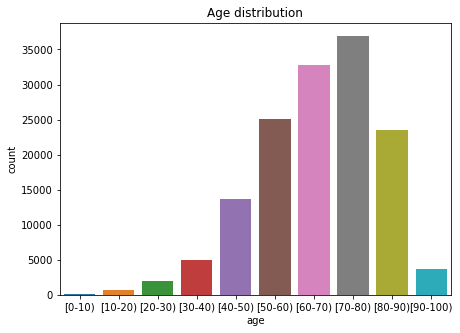

In [10]:
# d. Please describe the demographic distributions in the dataset for the age and gender fields.
plt.figure(figsize=(7, 5))
sns.countplot(x='age', data=df_new)
plt.title('Age distribution')
plt.show()

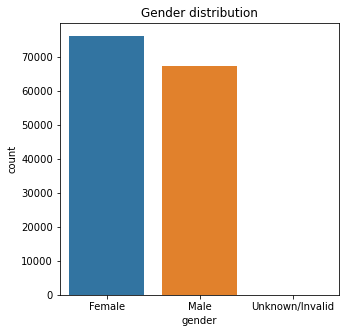

In [11]:
plt.figure(figsize=(5, 5))
sns.countplot(x='gender', data=df_new)
plt.title('Gender distribution')
plt.show()

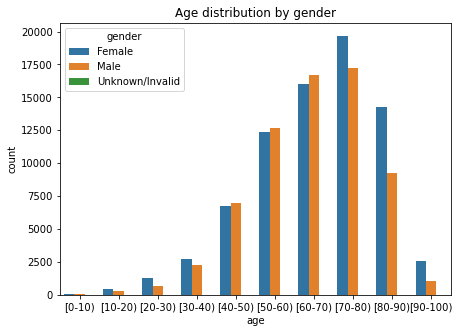

In [12]:
plt.figure(figsize=(7, 5))
sns.countplot(x='age', hue="gender", data=df_new)
plt.title('Age distribution by gender')
plt.show()

**Response Q2d**: The demographic distributions in the dataset for the age and gender fields are shown above. The quick analysis revealed that the dataset mostly represented by male and female in the age range between 40 and 90 years old. The ratio of female and male of age 0 to 70 are about the same. The number of female patients in age between 70 and 100 are higher than males in the same age range.

In [13]:
######NOTE: The visualization will only display in Chrome browser. ########
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [14]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [15]:
df_new.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,nan,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,nan,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,nan,nan,276,250.01|255,0,0,0,59,9,18,0,68071-1701,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,nan,nan,648,250|V27,2,1,0,11,6,13,5,0378-1110,No,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,nan,nan,8,250.43|403,0,0,0,44,7,16,1,68071-1701,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,nan,nan,197,157|250,0,0,0,51,5,8,0,0049-4110,Ch,NO


In [16]:
from student_utils import reduce_dimension_ndc
%autoreload

In [17]:
reduce_dim_df = reduce_dimension_ndc(df_new, ndc_code_df)

In [18]:
# Number of unique values should be less for the new output field
assert df_new['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [19]:
reduce_dim_df.nunique()

encounter_id                78304
patient_nbr                 56133
race                            6
gender                          3
age                            10
admission_type_id               8
discharge_disposition_id       25
admission_source_id            17
time_in_hospital               14
payer_code                     18
medical_specialty              73
primary_diagnosis_code        682
other_diagnosis_codes       16466
number_outpatient              39
number_inpatient               19
number_emergency               31
num_lab_procedures            115
number_diagnoses               16
num_medications                75
num_procedures                  7
ndc_code                      251
change                          2
readmitted                      3
generic_drug_name              36
dtype: int64

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [20]:
from student_utils import select_first_encounter
%autoreload
first_encounter_df = select_first_encounter(reduce_dim_df)

In [21]:
first_encounter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56133 entries, 0 to 56132
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   patient_nbr               56133 non-null  int64 
 1   encounter_id              56133 non-null  int64 
 2   race                      56133 non-null  object
 3   gender                    56133 non-null  object
 4   age                       56133 non-null  object
 5   admission_type_id         56133 non-null  object
 6   discharge_disposition_id  56133 non-null  object
 7   admission_source_id       56133 non-null  object
 8   time_in_hospital          56133 non-null  int64 
 9   payer_code                56133 non-null  object
 10  medical_specialty         56133 non-null  object
 11  primary_diagnosis_code    56133 non-null  object
 12  other_diagnosis_codes     56133 non-null  object
 13  number_outpatient         56133 non-null  int64 
 14  number_inpatient      

In [22]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56133
Number of unique encounters:56133
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [23]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [24]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [25]:
agg_drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56133 entries, 0 to 56132
Data columns (total 57 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   patient_nbr                                 56133 non-null  int64 
 1   encounter_id                                56133 non-null  int64 
 2   race                                        56133 non-null  object
 3   gender                                      56133 non-null  object
 4   age                                         56133 non-null  object
 5   admission_type_id                           56133 non-null  object
 6   discharge_disposition_id                    56133 non-null  object
 7   admission_source_id                         56133 non-null  object
 8   time_in_hospital                            56133 non-null  int64 
 9   payer_code                                  56133 non-null  object
 10  medical_specialty     

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

medical_specialty         48.094704
payer_code                41.542408
race                       2.837903
primary_diagnosis_code     0.014252


/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


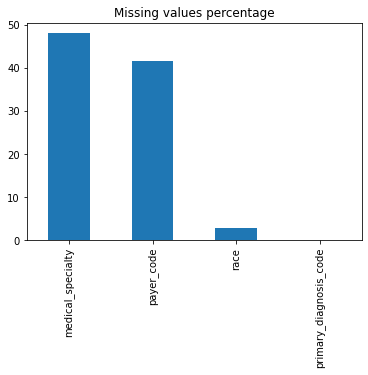

In [26]:
# Let's check agg_drug_df for NaN 
nan_df = (agg_drug_df == 'nan').mean().sort_values(ascending=False)*100
print(nan_df[nan_df > 0.].to_string(header=None))
nan_df[nan_df > 0.].plot(kind='bar', )
plt.title('Missing values percentage')
plt.show()

In [27]:
missed_primary_code = agg_drug_df[agg_drug_df['primary_diagnosis_code'] == 'nan']
missed_primary_code

,patient_nbr,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,change,readmitted,generic_drug_name_array,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide
1034,520452,8927178,Caucasian,Male,[60-70),3,1,1,3,nan,Urology,nan,250.82|401,0,0,0,42,5,18,1,47918-902,Ch,NO,[Afrezza],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1648,916947,20095914,AfricanAmerican,Male,[70-80),3,5,1,1,nan,Urology,nan,250.01|428,0,0,0,12,7,10,2,68071-1701,No,>30,[Novolin R],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4820,3650130,10122996,AfricanAmerican,Male,[60-70),3,1,1,5,nan,Urology,nan,276|594,0,0,0,31,8,25,2,42385-904,Ch,NO,[Metformin Hydrochloride],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
17762,25300467,117010956,Hispanic,Male,[40-50),1,2,1,4,MC,nan,nan,780|295,0,3,0,31,9,20,0,0173-0863,Ch,<30,[Avandia 4MG],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18475,27758448,163172034,Caucasian,Female,[80-90),1,1,1,2,nan,nan,nan,V63|414,0,0,0,30,6,14,0,47918-902,No,NO,[Afrezza],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22679,39688524,164326842,AfricanAmerican,Male,[40-50),3,7,7,3,OG,Emergency/Trauma,nan,276|V08,0,0,0,66,8,16,0,0049-4110,Ch,NO,[Glucotrol],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31987,59785542,169067490,AfricanAmerican,Female,[80-90),1,6,7,8,MC,nan,nan,427|486,0,0,0,62,8,13,0,47918-891,Ch,NO,[Afrezza],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
53134,113173146,273014598,Hispanic,Male,[60-70),1,3,1,4,nan,InternalMedicine,nan,250.02|438,0,0,1,38,4,12,0,42291-582,No,<30,[Metformin Hydrochloride],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
missed_gender = agg_drug_df[(agg_drug_df['gender'] != 'Male') & (agg_drug_df['gender'] != 'Female')]
missed_gender 

,patient_nbr,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,change,readmitted,generic_drug_name_array,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide
37945,78119847,257364294,nan,Unknown/Invalid,[70-80),1,22,7,8,CP,nan,850,805|808,0,0,0,59,9,21,2,0173-0861,Ch,NO,[Avandia 2MG],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48777,100695042,98634858,Other,Unknown/Invalid,[70-80),3,1,1,1,nan,Cardiology,414,411|401,0,0,0,5,4,22,5,0591-0460,Ch,NO,[Glipizide],0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Response Q5**: Previously we have removed columns with more that 50% missed data. Here are the list of these features:
- weight
- max_glu_serum
- A1Cresult

In the aggregated dataset the medical_specialty (48% missed values) and payer_code (41% missed values) needed to be removed too because of high percentages of missed values.

There are 8 patients with missed primary_diagnosis_code, which will be removed from the final dataset.

There are 2 patients with Unknown/Invalid gender, which will be removed from the final dataset too.

In [29]:
agg_drug_df_final = agg_drug_df.drop(columns = ['medical_specialty', 'payer_code'])
agg_drug_df_final = agg_drug_df_final.drop(index=missed_primary_code.index)
agg_drug_df_final = agg_drug_df_final.drop(index=missed_gender.index)
display(agg_drug_df_final.info())
display(agg_drug_df_final.describe())
agg_drug_df_final.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56123 entries, 0 to 56132
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   patient_nbr                                 56123 non-null  int64 
 1   encounter_id                                56123 non-null  int64 
 2   race                                        56123 non-null  object
 3   gender                                      56123 non-null  object
 4   age                                         56123 non-null  object
 5   admission_type_id                           56123 non-null  object
 6   discharge_disposition_id                    56123 non-null  object
 7   admission_source_id                         56123 non-null  object
 8   time_in_hospital                            56123 non-null  int64 
 9   primary_diagnosis_code                      56123 non-null  object
 10  other_diagnosis_codes 

None

,patient_nbr,encounter_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide
count,5.612300e+04,5.612300e+04,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.000000,56123.00000,56123.000000,56123.000000,56123.000000
mean,5.528803e+07,1.595961e+08,4.418705,0.299735,0.216364,0.115639,43.601643,7.283930,16.607933,1.419917,0.000873,0.338970,0.000873,0.020509,0.015983,0.021863,0.045080,0.000036,0.004686,0.001782,0.048590,0.007626,0.053009,0.001354,0.001408,0.024339,0.000036,0.045133,0.000588,0.074105,0.003439,0.000053,0.001978,0.257274,0.021382,0.000285,0.001764,0.003546,0.001693,0.00114,0.000071,0.000303,0.000232
std,3.943169e+07,1.007869e+08,2.987185,1.108425,0.663083,0.546695,20.111282,1.990608,8.477303,1.766948,0.029535,0.473364,0.029535,0.141733,0.125410,0.146236,0.207481,0.005970,0.068295,0.042174,0.215011,0.086995,0.224053,0.036774,0.037492,0.154102,0.005970,0.207598,0.024242,0.261944,0.058542,0.007311,0.044429,0.437136,0.144654,0.016882,0.041963,0.059441,0.041108,0.03375,0.008442,0.017402,0.015218
min,1.350000e+02,1.252200e+04,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,2.348588e+07,8.407786e+07,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,4.811520e+07,1.470016e+08,4.000000,0.000000,0.000000,0.000000,45.000000,8.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,8.771141e+07,2.209428e+08,6.000000,0.000000,0.000000,0.000000,58.000000,9.000000,21.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.895026e+08,4.438423e+08,14.000000,42.000000,12.000000,42.000000,132.000000,16.000000,81.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,

,patient_nbr,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,change,readmitted,generic_drug_name_array,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide
0,135,24437208,Caucasian,Female,[50-60),2,1,1,8,401,997|560,0,0,0,77,8,33,6,68071-1701,Ch,<30,[Novolin R],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,729,189899286,Caucasian,Female,[80-90),1,3,7,4,820,493|E880,0,0,0,68,9,23,2,0615-7982,No,NO,[Metformin Hydrochloride],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,774,64331490,Caucasian,Female,[80-90),1,1,7,3,274,427|416,0,0,0,46,9,20,0,0115-1743,Ch,NO,[Glyburide],0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,927,14824206,AfricanAmerican,Female,[30-40),1,1,7,5,590,220|250,0,0,0,49,3,5,0,42571-104,No,NO,[Glimepiride],0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1152,8380170,AfricanAmerican,Female,[50-60),1,1,7,6,282,250.01|?,0,1,0,43,2,13,2,47918-902,No,>30,[Afrezza],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_col_list = ['race', 'gender', 'age']
categorical_col_list = ['primary_diagnosis_code'] + required_col_list + ndc_col_list
numerical_col_list = ['num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']
PREDICTOR_FIELD = 'time_in_hospital'

In [31]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return df[selected_col_list]


In [32]:
selected_features_df = select_model_features(agg_drug_df_final, categorical_col_list, numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [33]:
processed_df = preprocess_df(selected_features_df, categorical_col_list, 
        numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [34]:
from student_utils import patient_dataset_splitter
%autoreload
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [35]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [36]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df_final['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0      7530
2.0      9472
3.0     10026
4.0      7679
5.0      5565
6.0      4122
7.0      3231
8.0      2417
9.0      1655
10.0     1292
11.0     1054
12.0      807
13.0      702
14.0      571
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


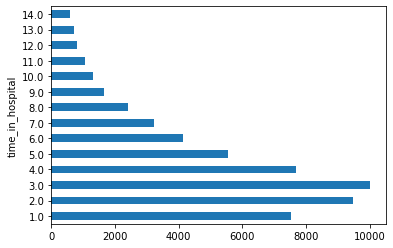

In [37]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     4530
2.0     5702
3.0     6006
4.0     4633
5.0     3290
6.0     2502
7.0     1926
8.0     1446
9.0      997
10.0     775
11.0     627
12.0     476
13.0     417
14.0     346
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


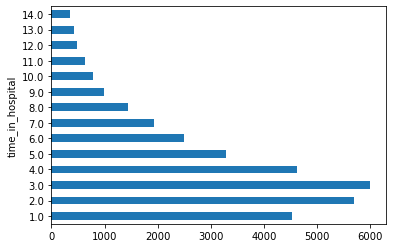

In [38]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     1517
2.0     1852
3.0     1955
4.0     1531
5.0     1170
6.0      818
7.0      681
8.0      494
9.0      310
10.0     266
11.0     213
12.0     176
13.0     130
14.0     112
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


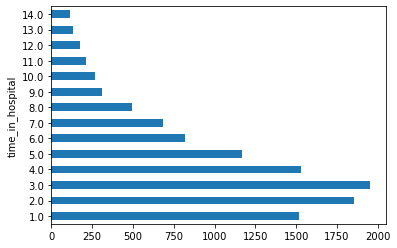

In [39]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female    29581
Male      26542
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


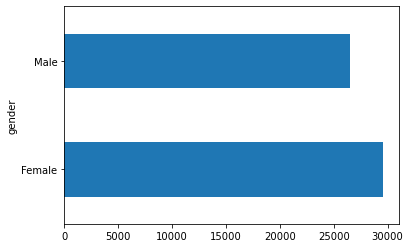

In [40]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    17687
Male      15986
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


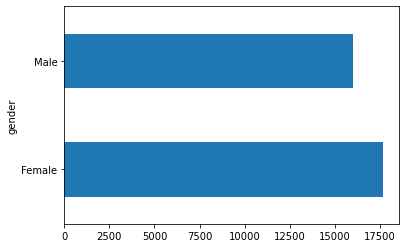

In [41]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    5885
Male      5340
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


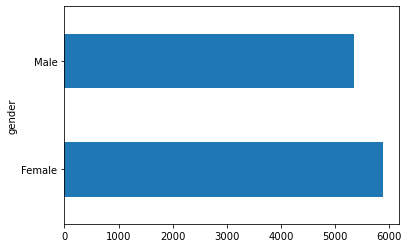

In [42]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [43]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [44]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [45]:
vocab_file_list = build_vocab_files(d_train, categorical_col_list)
vocab_file_list

['./diabetes_vocab/primary_diagnosis_code_vocab.txt',
 './diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Afrezza_vocab.txt',
 './diabetes_vocab/Amaryl_vocab.txt',
 './diabetes_vocab/Avandia_2MG_vocab.txt',
 './diabetes_vocab/Avandia_4MG_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glucophage_vocab.txt',
 './diabetes_vocab/Glucophage_XR_vocab.txt',
 './diabetes_vocab/Glucotrol_vocab.txt',
 './diabetes_vocab/Glucotrol_XL_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glynase_vocab.txt',
 './diabetes_vocab/Glyset_vocab.txt',
 './diabetes_vocab/Humulin_R_vocab.txt',
 './diabetes_voc

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [46]:
from student_utils import create_tf_categorical_feature_cols
%autoreload
tf_cat_col_list = create_tf_categorical_feature_cols(categorical_col_list)

INFO:tensorflow:vocabulary_size = 604 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in Acarbose is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Acarbose_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in Afrezza is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Afrezza_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in Amaryl is inferred from the number of elements in the vocabulary_f

In [47]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_vocab.txt', vocabulary_size=604, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 605), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [48]:
from student_utils import create_tf_numeric_feature
%autoreload

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [49]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [50]:
tf_cont_col_list = create_tf_numerical_feature_cols(numerical_col_list, d_train)

In [51]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7fa3b3330cb0>, mean=43.59650164820479, std=20.05243236103567))

tf.Tensor(
[[ 1.1 ]
 [ 1.2 ]
 [-0.2 ]
 [-0.6 ]
 [-0.6 ]
 [ 0.05]
 [ 1.4 ]
 [ 0.85]
 [-0.45]
 [-0.45]
 [ 1.  ]
 [-0.85]
 [ 0.3 ]
 [ 1.95]
 [ 0.15]
 [-2.1 ]
 [ 0.15]
 [ 0.75]
 [ 1.15]
 [-0.35]
 [-0.15]
 [ 0.9 ]
 [ 1.75]
 [ 1.3 ]
 [ 1.1 ]
 [ 0.7 ]
 [-2.1 ]
 [ 1.35]
 [ 1.2 ]
 [ 0.2 ]
 [ 0.95]
 [-0.2 ]
 [ 0.3 ]
 [ 0.25]
 [ 1.45]
 [ 2.  ]
 [ 1.4 ]
 [-0.9 ]
 [ 0.  ]
 [-0.35]
 [-1.15]
 [-2.05]
 [ 0.35]
 [-0.55]
 [ 0.5 ]
 [-1.55]
 [-2.1 ]
 [ 0.95]
 [-0.45]
 [ 0.75]
 [ 0.25]
 [-0.55]
 [ 0.5 ]
 [-0.15]
 [ 1.3 ]
 [ 0.1 ]
 [ 0.55]
 [-0.45]
 [ 1.45]
 [-0.35]
 [ 0.55]
 [ 0.65]
 [-1.3 ]
 [-0.75]
 [-1.95]
 [ 1.4 ]
 [-1.1 ]
 [-0.15]
 [-0.15]
 [-0.35]
 [-0.9 ]
 [-0.6 ]
 [ 1.35]
 [ 0.55]
 [ 2.1 ]
 [-1.2 ]
 [ 0.6 ]
 [ 0.75]
 [ 0.25]
 [-1.45]
 [-1.7 ]
 [ 

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [52]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below is a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. 

In [100]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer, epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric, 'mae'])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=5)
    reduce_l_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                  verbose=1, 
                                  factor=0.5,
                                  patience=2,
                                  min_lr=1e-7)
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop, reduce_l_rate],
                        epochs=epochs)
    return model, history 

In [101]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=100)

Train for 264 steps, validate for 88 steps
Epoch 1/100
264/264 [==============================] - 14s 54ms/step - loss: 29.2853 - mse: 29.1603 - mae: 4.2545 - val_loss: 22.7783 - val_mse: 22.5085 - val_mae: 3.6382
Epoch 2/100
264/264 [==============================] - 9s 35ms/step - loss: 20.8779 - mse: 20.3832 - mae: 3.4029 - val_loss: 16.4091 - val_mse: 15.4874 - val_mae: 2.9666
Epoch 3/100
264/264 [==============================] - 10s 37ms/step - loss: 15.6352 - mse: 14.9052 - mae: 2.8913 - val_loss: 12.7456 - val_mse: 11.7415 - val_mae: 2.5919
Epoch 4/100
264/264 [==============================] - 9s 34ms/step - loss: 13.2143 - mse: 12.2767 - mae: 2.6106 - val_loss: 12.9018 - val_mse: 12.0318 - val_mae: 2.5497
Epoch 5/100
264/264 [==============================] - 9s 35ms/step - loss: 12.4908 - mse: 11.5807 - mae: 2.5313 - val_loss: 11.0703 - val_mse: 10.1492 - val_mae: 2.3281
Epoch 6/100
264/264 [==============================] - 9s 35ms/step - loss: 11.9415 - mse: 11.0857 - mae:

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [102]:
feature_list = categorical_col_list + numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [103]:
from student_utils import get_mean_std_from_preds
%autoreload
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [104]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [105]:
prob_output_df

,pred,actual_value,pred_mean,pred_std
0,5.867435,2.0,2.962003,0.690753
1,1.738754,1.0,3.657044,0.692289
2,5.466702,2.0,2.574178,0.690015
3,4.284372,3.0,3.082757,0.691434
4,7.562634,5.0,4.681446,0.694078
...,...,...,...,...
11220,6.942092,6.0,6.837343,0.698517
11221,2.219670,5.0,5.872707,0.696169
11222,5.398631,4.0,3.830534,0.692700
11223,6.398046,1.0,2.379936,0.689768


In [141]:
model_r2_score = r2_score(prob_output_df['actual_value'], prob_output_df['pred_mean'])
model_rmse = np.sqrt(mean_squared_error(prob_output_df['actual_value'], prob_output_df['pred_mean']))
print(f'Probablistic model evaluation metrics based on the mean of predictions using test dataset: \nRMSE = {model_rmse:.2f}, \nR2-score = {model_r2_score:.2f}')

Probablistic model evaluation metrics based on the mean of predictions using test dataset: 
RMSE = 2.32, 
R2-score = 0.39


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [106]:
from student_utils import get_student_binary_prediction
%autoreload
threshold = 5
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean', threshold)

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [107]:
def add_pred_to_test(df, pred_np, demo_col_list):
    test_df = df.copy()
    for c in demo_col_list:
        test_df[c] = df[c].astype(str)
    test_df['label_value'] = df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    test_df.reset_index(inplace=True)
    test_df['score'] = pred_np
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])


In [108]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,1314,Female,Caucasian,2.0,0,0
1,8208,Male,Caucasian,1.0,0,0
2,8460,Male,Caucasian,2.0,0,0
3,11511,Male,Caucasian,3.0,0,0
4,15210,Male,Caucasian,5.0,0,1


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [126]:
# Extra helper functions to evaluate training process and the model
def plot_roc_curve(ground_truth, probability, legend='Estimated hospitalization time', f_name='roc_eht.png'):
    '''
    This fucntions accepts imputs:
    ground_truth: list, array, or data series 
    probability: list, array, or data series
    It plots ROC curve and calculates AUC
    '''
    fpr, tpr, _ = roc_curve(ground_truth, probability)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', 
             lw=2, label=f'{legend} (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc=4)
    plt.savefig(f_name)
    plt.show()
    return

# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(ground_truth, probability, legend='Estimated hospitalization time', f_name='pr_rec_eht.png'):
    '''
    This fucntions accepts imputs:
    ground_truth: list, array, or data series 
    probability: list, array, or data series
    It plots Precision-Recall curve and caclulates average precision-recall score
    '''
    average_precision = average_precision_score(ground_truth, probability)
    precision, recall, _ = precision_recall_curve(ground_truth, probability)
    plt.figure(figsize=(5, 5))
    plt.plot(recall, precision, color='darkblue', 
             lw=2, label=f'{legend} (AP score: {average_precision:0.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve')
    plt.legend(loc=3)
    plt.savefig(f_name)
    plt.show()
    return
    
#Also consider plotting the history of your model training:

def plot_history(history, f_name='hist_eht.png'):
    
    x = range(len(history['val_loss']))
    fig, axs= plt.subplots(1, 2, figsize=(14,7))
    fig.suptitle('Training history plots')
    axs[0].plot(x, history['loss'], color='r', label='train loss MSE')
    axs[0].plot(x, history['val_loss'], color='b', label='valid loss MSE')
    axs[0].set_title('Trainin/validation loss')
    axs[0].legend(loc=0)
    axs[1].plot(x, history['mae'], color='r', label='train MAE')
    axs[1].plot(x, history['val_mae'], color='b', label='valid MAE')
    axs[1].set_title('Trainin/validation MAE')
    axs[1].legend(loc=0)
    plt.savefig(f_name)
    plt.show()
    return

In [127]:
# AUC, F1, precision and recall
# Summary
y_true = pred_test_df['label_value'].values
y_pred = pred_test_df['score'].values
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      6855
           1       0.77      0.54      0.63      4370

    accuracy                           0.76     11225
   macro avg       0.76      0.72      0.73     11225
weighted avg       0.76      0.76      0.75     11225



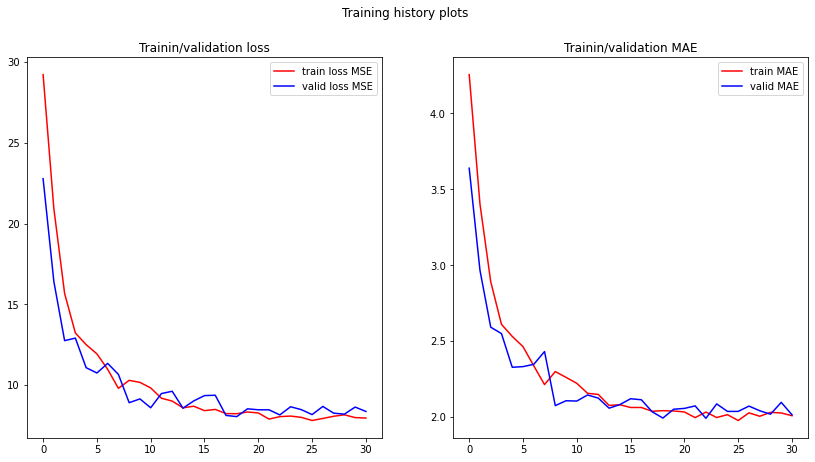

In [128]:
plot_history(history.history)

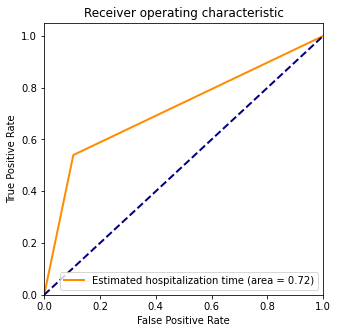

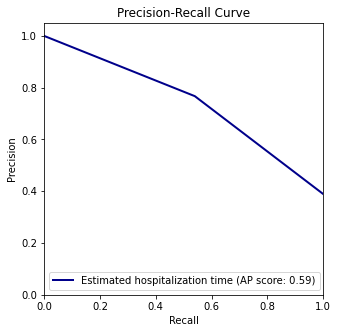

In [129]:
plot_roc_curve(y_true, y_pred)
plot_precision_recall_curve(y_true, y_pred)

**Response Q11**:  

First of all, we need to take into account that we trained a regression model to predict estimated hospitalization time. The root mean squared error, RMSE, of the model on test dataset is 2.32 which is in the range of standard deviation of the dataset (2.2). The Coefficient of determination, R2-score, is 0.39, which means that the model can explain 39% of variance. Taking into account these values, we can assume that our model is OK, due to acceptable RMSE and R2-score, therefore it is a good starter model, and in order to deploy it, the model have to be improved.

The regression model was converted to classification model this threshold of 5 days in the hospital. 
The model exibit good precision and recall (both weighted avgerage values are 0.76). 

The precision looks at the number of positive cases accurately identified divided by all of the cases identified as positive by the algorithm no matter whether they are identified right or wrong. A high precision test gives you more confidence that a positive test result is actually positive, however, does not take false negatives into account. A high precision test could still miss a lot of positive cases. High-precision tests are beneficial when you want to confirm a suspected diagnosis, and in our case is to confirm the hospitalization time of > 5 days. 

When a high recall test returns a negative result, you can be confident that the result is truly negative since a high recall test has low false negatives. Recall does not take false positives into account. Because of this, high recall tests are good when you want to make sure someone doesn’t have a disease, and in our case is to confirm hospitalization time less than 5 days. 

Optimizing one of these metrics usually comes at the expense of sacrificing the other. 


In fact, the mean of the time in the hospital is 4.4 and in order to improve classification model we may need to vary this threshold in order to maximize F1 score (harmonic mean of precision and recall) or other classification model evaluation metrics. It might be worth to use Matthew’s correlation coefficient (MCC), which is a good measure of model quality for binary classes because it takes into account all four values in the confusion matrix (TP, FP, TN, and FN), to find a better threshold.

The training history plots clearly shows that we still can keep training to get a little bit better MSE. There is no observable overfitting. Therefore, it looks like the model needed to be tuned (different optimizer, some other callbacks) or architecture of the model have to be changed in order to get improvements. Also, we may need to reconsider the selected feature. In addition the ensemble approach could help to improve the model performance.

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [142]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [3074]}


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [143]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

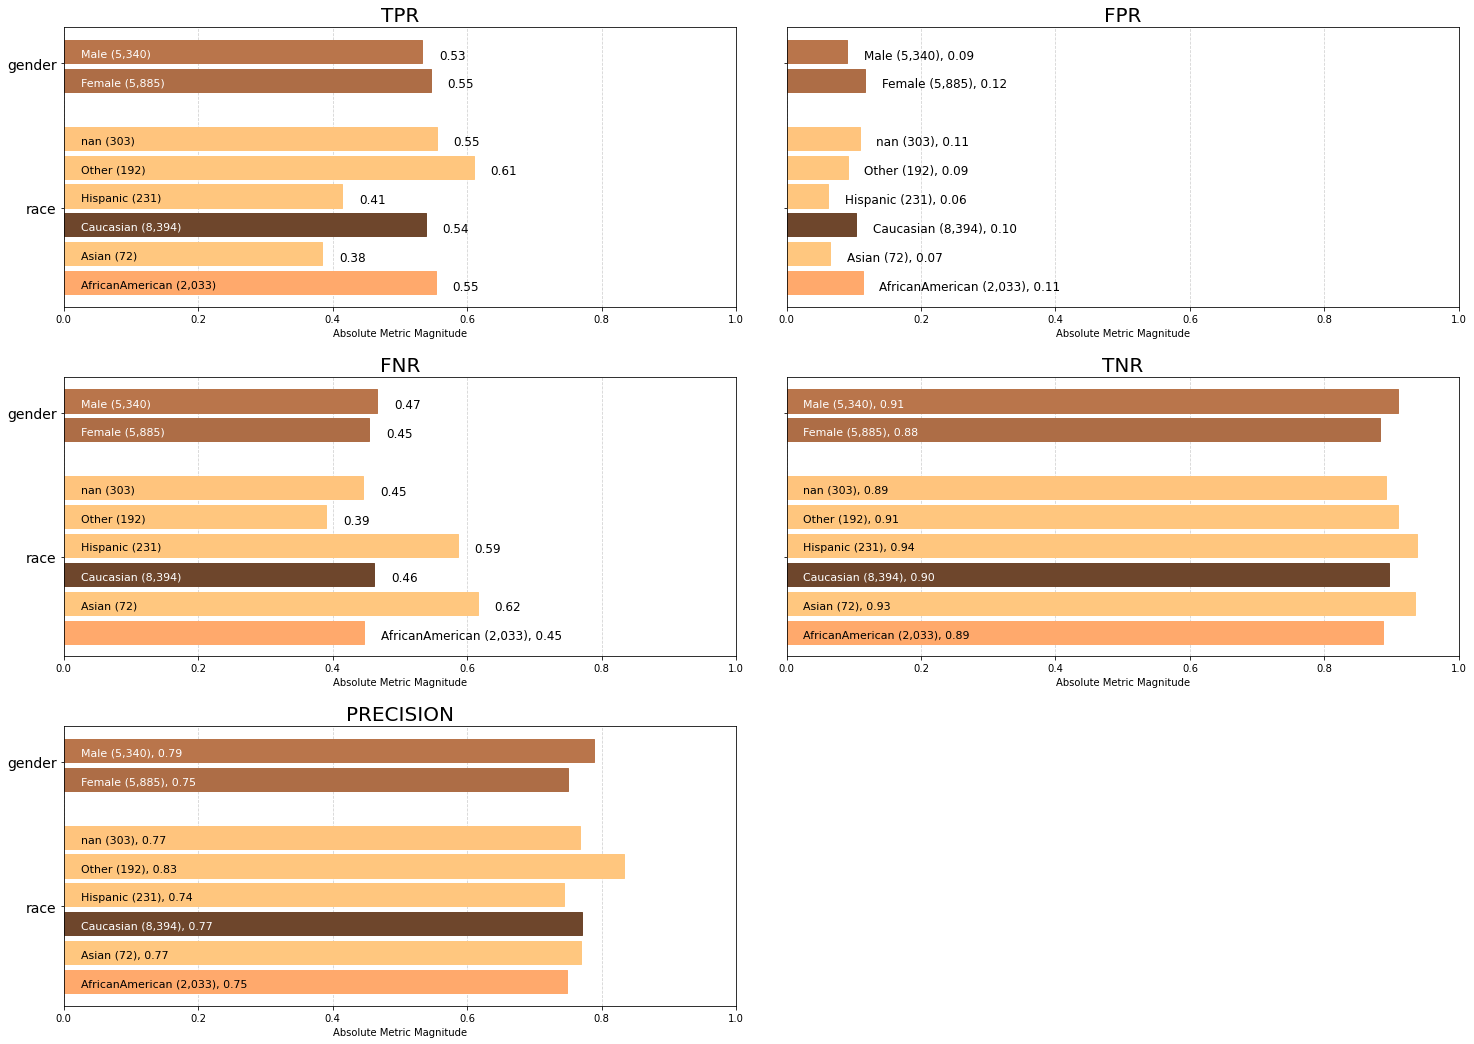

In [158]:
# Plot two metrics
# Is there significant bias in your model for either race or gender?
p = aqp.plot_group_metric_all(clean_xtab, metrics=['tpr', 'fpr', 'fnr', 'tnr', 'precision'], ncols=2)

**Response Q12**: 

For the gender and race fields, there is no significant bias in the model across any of the groups. 
Therefore, Hispanic and Asian race has lower recall and with higher FNR (error type II, falsely identified staying less than 5 days). The FPR for females are little bit higher (error type I), which means that the females will be more falsely identified for staying more than 5 days in the hospital compare to males. 
The precision is a little bit better for males, which means that the time staying in the hospital for males will be a little bit more accurate.

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

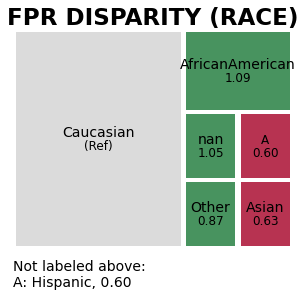

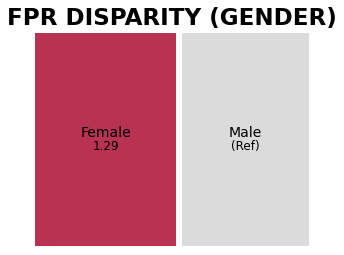

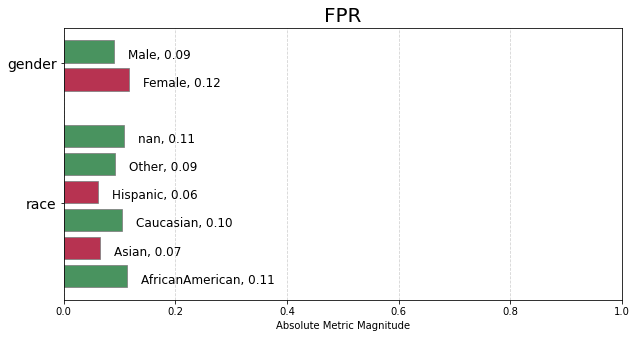

In [160]:
# Reference group fairness plot
fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='fpr', attribute_name='race')
fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='fpr', attribute_name='gender')
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

**Response Q13**: 

- Hispanic and Asian are less (~40%) likely to be falsely identified (FPR Disparity 0.6 and 0.63 respectively) relative to Caucasian.

- Females are more (~29%) likely to be falsely identified (FPR Disparity 1.29) relative to males.